In [64]:
import numpy as np
import pandas as pd
import pickle as pkl
import sklearn
import nltk
import os

from nltk.corpus import stopwords 
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = '../data/input/imperatives/ground_truth/'
OUTPUT_DIR = '../data/'
MODEL_DIR = '../models/'

In [3]:
ip_file = os.path.join(INPUT_DIR, 'imperatives_binary_data.csv')
df_data_raw = pd.read_csv(ip_file)

In [4]:
df_data_raw

,text,label
0,Find a sturdy piece of cardboard in the form o...,1
1,Stand up for yourself,1
2,Fix out priorities together in a meeting a co...,1
3,Make one last snowball for the penguin's head,1
4,Look for the internet venue you will use for y...,1
...,...,...
2319,it's a Finnish documentary but it has all thes...,0
2320,yeah because you took time when you had your ...,0
2321,oh come on you're kidding right.,0
2322,You see.,0


In [5]:
data = df_data_raw['text']
label = df_data_raw['label']

from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.20, 
                                                                  random_state=0, stratify=label)

In [6]:
df_data_raw_train = pd.DataFrame(list(zip(data_train, label_train)), columns=['text', 'label'])
df_data_raw_test = pd.DataFrame(list(zip(data_test, label_test)), columns=['text', 'label'])

In [ ]:
raw_train_file = INPUT_DIR + 'data_train.pkl'
with open(raw_train_file, 'wb') as f_op:
    pkl.dump(df_data_raw_train, f_op)
    
    
raw_test_file = INPUT_DIR + 'data_test.pkl'
with open(raw_test_file, 'wb') as f_op:
    pkl.dump(df_data_raw_test, f_op)

In [7]:
print(df_data_raw_train.shape, df_data_raw_test.shape)

(1859, 2) (465, 2)


In [8]:
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = []
    # antonyms = []

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
                
    return list(set(synonyms))

In [9]:
import re

def replace_synonym(sentence, word):
    
    augmented_sentences = []
    augmented_sentences.append(sentence)
    
    sentence_words = sentence.split(' ')
    
    if word in sentence_words:
        
        synonyms = get_synonyms(word)
    
        for synonym in synonyms:
            reg_ex = r'\b'+word+r'\b'
            new_setence = re.sub(reg_ex, synonym, sentence)
        
            augmented_sentences.append(new_setence)
        
    return augmented_sentences

In [14]:
def synonym_augmentation(sentence):
    
    sentences = []
    
    words = sentence.split(' ')
    
    for word in words:
        # print('---------------------\n', word)
        new_sentences = replace_synonym(sentence, word)
        # print(new_sentences)
        sentences.extend(new_sentences)
        
    return list(set(sentences))

In [15]:
def synonym_augmentation_withoutstopwords(sentence):
    
    sentences = []
    
    words = sentence.split(' ')
    
    for word in words:
        # print('---------------------\n', word)
        if word not in stopwords.words('english'):
            new_sentences = replace_synonym(sentence, word)
            # print(new_sentences)
            sentences.extend(new_sentences)
        
    return list(set(sentences))

In [12]:
df_imperative_train = df_data_raw_train.loc[df_data_raw_train['label'] == 1]
df_nonimperative_train = df_data_raw_train.loc[df_data_raw_train['label'] == 0]

# df_imperative_test = df_data_raw_test.loc[df_data_raw_test['label'] == 1]
# df_nonimperative_test = df_data_raw_test.loc[df_data_raw_test['label'] == 0]

In [16]:
def get_augmented_dataframe(sentence, label):
    
    augmented_sentences = synonym_augmentation_withoutstopwords(sentence)
    labels = [label] * len(augmented_sentences)
    
    df = pd.DataFrame(list(zip(augmented_sentences, labels)), columns=['text', 'label'])
    
    return df

In [17]:
df_aug_imperative_train = pd.DataFrame(columns=['text', 'label'])
for index, row in df_imperative_train.iterrows():
    
    sentence = row['text']
    label = row['label']
    
    df = get_augmented_dataframe(sentence, label)
    
    df_aug_imperative_train = pd.concat([df_aug_imperative_train, df], axis=0, sort=False)

In [18]:
df_aug_imperative_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53760 entries, 0 to 171
Data columns (total 2 columns):
text     53760 non-null object
label    53760 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [20]:
Counter(df_aug_imperative_train['label'])

Counter({1: 53760})

In [21]:
df_aug_imperative_train.head()

,text,label
0,Learn to enjoy cook from scratch,1
1,read to enjoy cooking from scratch,1
2,discover to enjoy cooking from scratch,1
3,Learn to enjoy cooking from incision,1
4,con to enjoy cooking from scratch,1


In [22]:
df_aug_nonimperative_train = pd.DataFrame(columns=['text', 'label'])
for index, row in df_nonimperative_train.iterrows():
    
    sentence = row['text']
    label = row['label']
    
    df = get_augmented_dataframe(sentence, label)
    
    df_aug_nonimperative_train = pd.concat([df_aug_nonimperative_train, df], axis=0, sort=False)

In [23]:
Counter(df_aug_nonimperative_train['label'])

Counter({0: 46362})

In [24]:
df_aug_nonimperative_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46362 entries, 0 to 442
Data columns (total 2 columns):
text     46362 non-null object
label    46362 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [25]:
df_aug_nonimperative_train.head()

,text,label
0,Gopher snakes in Arizona are not poisonous bu...,0
1,Gopher snakes in Arizona are not poisonous bu...,0
2,Gopher snakes in Arizona are not poisonous bu...,0
3,Gopher snakes in Arizona are not vicious but ...,0
4,Gopher snakes in Arizona are not poisonous bu...,0


In [26]:
df_data_train = pd.concat([df_aug_nonimperative_train, df_aug_imperative_train], axis=0, sort=False)

In [27]:
ip_file = os.path.join(INPUT_DIR, 'imperatives_binary_synonym_aug_train.csv')
df_data_train.to_csv(ip_file, index=False)

In [28]:
Counter(df_data_train['label'])

Counter({0: 46362, 1: 53760})

In [29]:
data_train = df_data_train['text']
label_train = df_data_train['label']

data_test = df_data_raw_test['text']
label_test = df_data_raw_test['label']

In [30]:
from collections import Counter

print('Training Data split', Counter(label_train))
print('Testing Data split', Counter(label_test))

Training Data split Counter({1: 53760, 0: 46362})
Testing Data split Counter({1: 234, 0: 231})


In [31]:
df_data_train = pd.DataFrame(list(zip(data_train, label_train)), columns=['text', 'label'])
df_data_test = pd.DataFrame(list(zip(data_test, label_test)), columns=['text', 'label'])

In [32]:
df_data_test.head()

,text,label
0,and my first paper I got a C on and I'd knew t...,0
1,Shut the door,1
2,I took some summer courses.,0
3,You better be quit!,1
4,So.,0


## Preprocess data

In [33]:
import re

def preprocess_text(text):
    
    # print(text, end ='')
    
    text = text.lower()
    text = re.sub(r'\W',' ', text)
    text = re.sub(' \d+', ' ', text)
    text = re.sub(r'\s+',' ', text)
        
    words = text.split(' ')
    words = [w.strip() for w in words]
    
    text = ' '.join(words)
    text = text.strip()
        
    # print(text)
    return text

In [34]:
def preprocess_df(df_data):
    df_data['processed_text'] = df_data['text'].apply(lambda x: preprocess_text(x))
    df_data.drop(df_data[df_data['processed_text'] == ''].index, inplace=True)
    
    return df_data

In [35]:
# Preprocess train & test data frame
print('Train before cleaning', df_data_train.shape)
df_data_train = preprocess_df(df_data_train)
print('Train after cleaning', df_data_train.shape)


print('Test before cleaning', df_data_test.shape)
df_data_test = preprocess_df(df_data_test)
print('Test after cleaning', df_data_test.shape)

Train before cleaning (100122, 2)
Train after cleaning (100122, 3)
Test before cleaning (465, 2)
Test after cleaning (465, 3)


In [36]:
df_data_test.head()

,text,label,processed_text
0,and my first paper I got a C on and I'd knew t...,0,and my first paper i got a c on and i d knew t...
1,Shut the door,1,shut the door
2,I took some summer courses.,0,i took some summer courses
3,You better be quit!,1,you better be quit
4,So.,0,so


### Create Corpus using only train data

In [37]:
corpus = df_data_train['text'].values
print('Corpus Length ', len(corpus))

Corpus Length  100122


### Vectorization

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

## Use Bag of Words Vectorizer for encoding`
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Vectorization of Train

In [39]:
data_train = vectorizer.transform(df_data_train['text'])
print('Shape of the data train:',data_train.shape)

Shape of the data train: (100122, 14035)


### Train

In [40]:
label_train = np.array(df_data_train['label'])
label_train = label_train.reshape((len(label_train), 1))
label_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

### Test


In [41]:
data_test = vectorizer.transform(df_data_test['text'])
print('Shape of the data train:',data_test.shape)

Shape of the data train: (465, 14035)


In [42]:
label_test = np.array(df_data_test['label'])
label_test = label_test.reshape((len(label_test), 1))

# Estimator

## SVM with poly (3) kernel - with stopwords

In [51]:
from sklearn.svm import SVC

# Run Logistic Regression
estimator = SVC(kernel='poly', degree=3)
estimator.fit(data_train, label_train)
predictions = estimator.predict(data_test)

predictions

/Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,

In [52]:
from sklearn.metrics import f1_score


## Accuracy Measure
print('Train Accuracy', estimator.score(data_train, label_train))
print('Test Accuracy', estimator.score(data_test, label_test))

# F1
f1_measure = f1_score(label_test, predictions, average='macro')
print('F1 macro Score: ', f1_measure)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Train Accuracy 0.9510519570460824
Test Accuracy 0.632258064516129
F1 macro Score:  0.5920403880785392
              precision    recall  f1-score   support

           0       0.84      0.32      0.46       231
           1       0.58      0.94      0.72       234

    accuracy                           0.63       465
   macro avg       0.71      0.63      0.59       465
weighted avg       0.71      0.63      0.59       465



In [53]:
model_file = MODEL_DIR + 'svm/' + 'model_svm_poly3_synonym_aug_withstopwords.pkl'
with open(model_file, 'wb') as f_op:
    pkl.dump(estimator, f_op)

## SVM with linear kernel - with stopwords

In [43]:
from sklearn.svm import SVC

estimator = SVC(kernel='linear')
estimator.fit(data_train, label_train)
predictions = estimator.predict(data_test)

predictions

/Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,

In [44]:
from sklearn.metrics import f1_score


## Accuracy Measure
print('Train Accuracy', estimator.score(data_train, label_train))
print('Test Accuracy', estimator.score(data_test, label_test))

# F1
f1_measure = f1_score(label_test, predictions, average='macro')
print('F1 macro Score: ', f1_measure)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(label_test, predictions))

Train Accuracy 0.9971035336888996
Test Accuracy 0.789247311827957
F1 macro Score:  0.7883064516129032
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       231
           1       0.76      0.85      0.80       234

    accuracy                           0.79       465
   macro avg       0.79      0.79      0.79       465
weighted avg       0.79      0.79      0.79       465



In [45]:
model_file = MODEL_DIR + 'svm/' + 'model_svm_linear_synonym_aug_withstopwords.pkl'
with open(model_file, 'wb') as f_op:
    pkl.dump(estimator, f_op)

## Deep Neural Network Model

In [56]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping

In [57]:
input_dim = data_train.shape[1]  # Number of features

In [59]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                140360    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 140,371
Trainable params: 140,371
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_vanillaNN = model.fit(data_train, label_train,
                    epochs=100,
                    verbose=True, 
                    validation_data=(data_test, label_test),
                    batch_size=10,
                    callbacks=[es])

Epoch 1/100
10013/10013 [==============================] - 7s 744us/step - loss: 0.0686 - accuracy: 0.9804 - val_accuracy: 0.8172 - val_loss: 0.8868
Epoch 2/100
10013/10013 [==============================] - 7s 735us/step - loss: 0.0142 - accuracy: 0.9952 - val_accuracy: 0.7978 - val_loss: 1.2907
Epoch 3/100
10013/10013 [==============================] - 7s 740us/step - loss: 0.0097 - accuracy: 0.9967 - val_accuracy: 0.7978 - val_loss: 1.5569
Epoch 4/100
10013/10013 [==============================] - 8s 751us/step - loss: 0.0072 - accuracy: 0.9979 - val_accuracy: 0.7935 - val_loss: 1.7281
Epoch 00004: early stopping


In [62]:
loss, accuracy = model.evaluate(data_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9956
Testing Accuracy:  0.8172


In [69]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

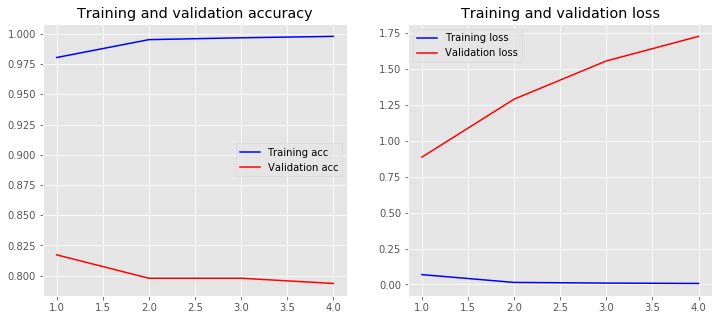

In [70]:
plot_history(history_vanillaNN)

## With embeddings

In [71]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus)

In [74]:
X_train = tokenizer.texts_to_sequences(df_data_train['text'].values)
X_test = tokenizer.texts_to_sequences(df_data_test['text'].values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(df_data_train['text'].values[2])
print(X_train[2])

Gopher snakes in Arizona are not poisonous  but when frightened they may hiss and shake their tush like rattlesnakes.
[1327, 1016, 8, 1293, 27, 33, 1175, 26, 38, 1350, 32, 117, 1414, 3, 1328, 87, 4067, 21, 1272]


In [76]:
print(df_data_test['text'].values[100])
print(X_test[100])

Push me away  I'll push you away.
[450, 20, 69, 292, 450, 5, 69]


In [77]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [79]:
print(X_train[2, :])

[1327 1016    8 1293   27   33 1175   26   38 1350   32  117 1414    3
 1328   87 4067   21 1272    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [81]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model_emb = Sequential()
model_emb.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(10, activation='relu'))
model_emb.add(layers.Dense(1, activation='sigmoid'))
model_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_emb.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           586000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                50010     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 636,021
Trainable params: 636,021
Non-trainable params: 0
_________________________________________________________________


In [86]:
history_embeddingNN = model_emb.fit(X_train, label_train,
                    epochs=100,
                    verbose=True, 
                    validation_data=(X_test, label_test),
                    batch_size=10,
                    callbacks=[es])

Epoch 1/100
10013/10013 [==============================] - 60s 6ms/step - loss: 0.0379 - accuracy: 0.9813 - val_accuracy: 0.8387 - val_loss: 0.7442
Epoch 2/100
10013/10013 [==============================] - 72s 7ms/step - loss: 0.0035 - accuracy: 0.9988 - val_accuracy: 0.8452 - val_loss: 0.8856
Epoch 3/100
10013/10013 [==============================] - 70s 7ms/step - loss: 0.0024 - accuracy: 0.9992 - val_accuracy: 0.8323 - val_loss: 1.0928
Epoch 4/100
10013/10013 [==============================] - 71s 7ms/step - loss: 0.0019 - accuracy: 0.9992 - val_accuracy: 0.8194 - val_loss: 1.5242
Epoch 00004: early stopping


ValueError: in user code:

    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /Users/talat/anaconda3/envs/sentgen/lib/python3.5/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 14035 but received input with shape [None, 100]


Training Accuracy: 0.9991
Testing Accuracy:  0.8387


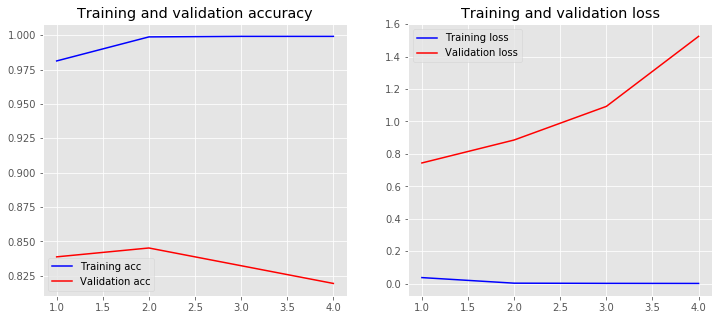

In [88]:
loss, accuracy = model_emb.evaluate(X_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_emb.evaluate(X_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_embeddingNN)